# Assignment 7: The NICEst Assignment - Kai Ponel & Hannan Mahadik 

# Custom

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions

from tensorflow.keras.layers import Layer, Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
class NICECouplingLayer(Layer):
    def __init__(self, input_dim, hidden_dim):
        super(NICECouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.network = self.build_network()

    def build_network(self):
        input_layer = tf.keras.Input(shape=(self.input_dim,))
        hidden_layer = LayerNormalization()(input_layer)
        hidden_layer = Dense(self.hidden_dim, activation='relu')(hidden_layer)
        hidden_layer = LayerNormalization()(hidden_layer)
        output_layer = Dense(self.input_dim)(hidden_layer)

        model = tf.keras.Model(input_layer, output_layer)
        return model

    def call(self, inputs, training=False):
        x1, x2 = tf.split(inputs, 2, axis=1)

        if training:
            y1 = x1
            y2 = x2 + self.network(x1)
        else:
            y1 = x1
            y2 = x2 - self.network(x1)

        return tf.concat([y1, y2], axis=1)

In [ ]:
class NICEModel(Layer):
    def __init__(self, input_dim, hidden_dim, num_coupling_layers):
        super(NICEModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_coupling_layers = num_coupling_layers
        self.coupling_layers = self.build_coupling_layers()
        self.diagonal_scale = self.add_weight(shape=(self.input_dim,),
                                              initializer='ones',
                                              trainable=True)

    def build_coupling_layers(self):
        layers = []
        for _ in range(self.num_coupling_layers):
            layers.append(NICECouplingLayer(self.input_dim // 2, self.hidden_dim))
            layers.append(NICECouplingLayer(self.input_dim // 2, self.hidden_dim))
        return layers

    def forward(self, x):
        for layer in self.coupling_layers:
            x = layer(x, training=True)
        return x * self.diagonal_scale

    def backward(self, y):
        y = y / self.diagonal_scale
        for layer in reversed(self.coupling_layers):
            y = layer(y, training=False)
        return y

In [ ]:
input_dim = 10  # Dimensionality of the input
hidden_dim = 1024  # Dimensionality of the hidden layer
num_coupling_layers = 4  # Number of coupling layers in the model

# Create the NICE model
nice_model = NICEModel(input_dim, hidden_dim, num_coupling_layers)

# Generate a random input tensor
input_tensor = tf.random.normal((1, input_dim))

# Forward pass through the NICE model
output_tensor = nice_model.forward(input_tensor)
print("Forward Output Tensor:", output_tensor)

# Inverse pass through the NICE model
reconstructed_tensor = nice_model.backward(output_tensor)
print("Inverse Reconstructed Tensor:", reconstructed_tensor)

# Calculate the difference between the original input and the reconstructed input
difference = tf.reduce_sum(tf.abs(input_tensor - reconstructed_tensor))
print("Difference:", difference.numpy())

Forward Output Tensor: tf.Tensor(
[[-0.9032111   0.52081865  1.2737176  -0.6568407  -0.5113207   1.5330367
   1.4914765  -7.0619383   5.7860475  -1.5632026 ]], shape=(1, 10), dtype=float32)
Inverse Reconstructed Tensor: tf.Tensor(
[[-0.9032111   0.52081865  1.2737176  -0.6568407  -0.5113207   0.19184715
   0.26891977 -0.88015985  1.2373682   0.76522535]], shape=(1, 10), dtype=float32)
Difference: 5.5134296e-07


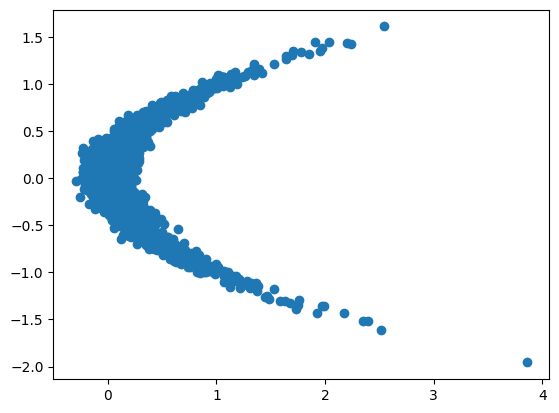

In [ ]:
n_samples = 2048
x2_dist = tfd.Normal(loc=0., scale=0.5)
x2_samples = x2_dist.sample(n_samples)
x1 = tfd.Normal(loc=1. * tf.square(x2_samples),
                scale=0.1*tf.ones(n_samples, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

as_np = x_samples.numpy()
plt.scatter(as_np[:, 0], as_np[:, 1])
a = plt.gca()
plt.show()

In [ ]:
input_dim = 2  # Dimensionality of the input
hidden_dim = 1024  # Dimensionality of the hidden layer
num_coupling_layers = 4  # Number of coupling layers in the model

# Create the NICE model
nice_model = NICEModel(input_dim, hidden_dim, num_coupling_layers)

In [ ]:
input_tensor = tf.convert_to_tensor(x_samples, dtype=tf.float32)

# Forward pass through the NICE model
output_tensor = nice_model.forward(input_tensor)
print("Forward Output Tensor:", output_tensor)

# Inverse pass through the NICE model
reconstructed_tensor = nice_model.backward(output_tensor)
print("Inverse Reconstructed Tensor:", reconstructed_tensor)

# Calculate the difference between the original input and the reconstructed input
difference = tf.reduce_sum(tf.abs(input_tensor - reconstructed_tensor))
print("Difference:", difference.numpy())

Forward Output Tensor: tf.Tensor(
[[ 0.19697177  0.3914664 ]
 [ 0.12130839 -0.3628856 ]
 [-0.09612302  0.26519707]
 ...
 [-0.02931317  0.13351545]
 [ 0.03520637  0.03869548]
 [ 0.00844221 -0.234889  ]], shape=(2048, 2), dtype=float32)
Inverse Reconstructed Tensor: tf.Tensor(
[[ 0.19697177  0.39146668]
 [ 0.12130839 -0.36288556]
 [-0.09612302  0.26519707]
 ...
 [-0.02931317  0.13351548]
 [ 0.03520637  0.0386955 ]
 [ 0.00844221 -0.234889  ]], shape=(2048, 2), dtype=float32)
Difference: 0.0


In [ ]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

In [ ]:
# Define the probability distribution for the latent space
latent_distribution = tfp.distributions.Normal(loc=0.0, scale=1.0)

In [ ]:
# Training loop
epochs = 20
batch_size = 32

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = x_samples.shape[0] // batch_size

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        batch_data = x_samples[start_idx:end_idx]

        with tf.GradientTape() as tape:
            latent_pred = nice_model.forward(batch_data)

            log_prob_forward = latent_distribution.log_prob(latent_pred)
            log_det_forward = tf.reduce_sum(tf.math.log(nice_model.diagonal_scale))
            log_prob_total = log_prob_forward + log_det_forward

            negative_log_likelihood = -tf.reduce_mean(log_prob_total)

        grads = tape.gradient(negative_log_likelihood, nice_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, nice_model.trainable_variables))

        epoch_loss += negative_log_likelihood.numpy()

    print("Epoch:", epoch + 1, "Loss:", epoch_loss / num_batches)

Epoch: 1 Loss: 1.2160893762484193
Epoch: 2 Loss: 0.9168199375271797
Epoch: 3 Loss: 0.8291278276592493
Epoch: 4 Loss: 0.7485119551420212
Epoch: 5 Loss: 0.6764731155708432
Epoch: 6 Loss: 0.6101751327514648
Epoch: 7 Loss: 0.5482662892900407
Epoch: 8 Loss: 0.48803867492824793
Epoch: 9 Loss: 0.4317939789034426
Epoch: 10 Loss: 0.3804547644685954
Epoch: 11 Loss: 0.33292743377387524
Epoch: 12 Loss: 0.28936798335053027
Epoch: 13 Loss: 0.25134043261641636
Epoch: 14 Loss: 0.21392354421550408
Epoch: 15 Loss: 0.17707627156050876
Epoch: 16 Loss: 0.1432654428499518
Epoch: 17 Loss: 0.11217657514498569
Epoch: 18 Loss: 0.08362137543736026
Epoch: 19 Loss: 0.05729438195703551
Epoch: 20 Loss: 0.03278769088501576


In [ ]:
# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

In [ ]:
# Create the NICE model with larger hidden layers and Layer Normalization
input_dim = 784  # Dimensionality of the input
hidden_dim = 500  # Dimensionality of the hidden layer
num_coupling_layers = 4  # Number of coupling layers in the mod
nice_model = NICEModel(input_dim, hidden_dim, num_coupling_layers)

In [ ]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

In [ ]:
# Define the loss function for maximum likelihood estimation
def negative_log_likelihood_loss(y_true, y_pred):
    log_prob = latent_distribution.log_prob(y_pred)
    return -tf.reduce_mean(log_prob)

In [ ]:
# Define the probability distribution for the latent space
latent_distribution = tfp.distributions.Normal(loc=0.0, scale=1.0)

In [ ]:
# Training loop
epochs = 10
batch_size = 128
# steps_per_sample = 100

train_losses = []
val_losses = []

for epoch in range(epochs):

    epoch_loss = 0.0
    num_batches = x_train.shape[0] // batch_size

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        batch_data = x_train[start_idx:end_idx]

        with tf.GradientTape() as tape:
            latent_pred = nice_model.forward(batch_data)
            loss_value = negative_log_likelihood_loss(batch_data, latent_pred)

        grads = tape.gradient(loss_value, nice_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, nice_model.trainable_variables))

        epoch_loss += loss_value.numpy()

    train_loss = epoch_loss / num_batches
    train_losses.append(train_loss)

    # Calculate validation loss
    val_loss = negative_log_likelihood_loss(x_test, nice_model.forward(x_test)).numpy()
    val_losses.append(val_loss)

    print("Epoch:", epoch + 1, "Train Loss:", train_loss, "Val Loss:", val_loss)

    # Generate and plot 8 sample images
    # latent_samples = tf.random.normal((10, input_dim))
    # generated_images = nice_model.backward(latent_samples)
    # generated_images = tf.reshape(generated_images, (10, 28, 28))

    # plt.figure(figsize=(10, 4))
    # for i in range(8):
    #     plt.subplot(2, 4, i + 1)
    #     plt.imshow(generated_images[i], cmap='gray')
    #     plt.axis('off')
    # plt.show()

Epoch: 1 Train Loss: 0.9938622418886576 Val Loss: 0.9441293
Epoch: 2 Train Loss: 0.9361718764417192 Val Loss: 0.93175805
Epoch: 3 Train Loss: 0.9282509213329381 Val Loss: 0.9264776
Epoch: 4 Train Loss: 0.9247228475207956 Val Loss: 0.92383116
Epoch: 5 Train Loss: 0.9227566166311247 Val Loss: 0.92224157
Epoch: 6 Train Loss: 0.9214636952194393 Val Loss: 0.921183
Epoch: 7 Train Loss: 0.9205961092415019 Val Loss: 0.9204128
Epoch: 8 Train Loss: 0.9200264961801023 Val Loss: 0.91994697
Epoch: 9 Train Loss: 0.9196618005760715 Val Loss: 0.91967636
Epoch: 10 Train Loss: 0.9194333999075441 Val Loss: 0.9194715


# Starter

In [ ]:
# 1st part: implement coupling layer
# - split input
# - implement y1 = x1, y2 = x2 + m(y1)   (forward)
# - implement backward


# one way to split could be
x1, x2 = tf.split(x, 2, axis=-1)
y1, y2 = whatever_the_coupling_layer_does(x1, x2)
y =  tf.concat([y1, y2], axis=-1)

# this is not so good, since it splits the data right through the middle.
# if the data has spatial relations, like images, this means the model
# conditions, say, the upper half of the image on the lower half, and vice versa.
# these long-range dependencies are hard to model.

# another option could be an even-odd split:
def split_even_odd(inp):
    even_inds = tf.range(0, inp.shape[1], 2)
    odd_inds = tf.range(1, inp.shape[1], 2)

    even = tf.gather(inp, even_inds, axis=1)
    odd = tf.gather(inp, odd_inds, axis=1)

    # process even and odd parts separately...
    ...
    
    # combine
    together = tf.stack([even_output, odd_output], axis=-1)
    return tf.reshape(together, tf.shape(inp))
    

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow as tf

In [ ]:
# 2nd part: NICE model
# - stack a bunch of coupling layers
# - switch x1, x2 for each layer
# - forward: apply coupling layers
# - backward: apply backward coupling layers (in reverse)

# - rescaling:
# - create d-dimensional vector (model weight)
# - forward: multiply x * exp(vector) after applying coupling layers
# - backwards: x / vector (or x * tf.exp(-vector)) BEFORE applying reverse coupling layers


# - training: map x -> h using NICE model
# - compute log_p_simple(h)
# - add log determinant of jacobian: simply sum of scaling values
# use -log_likelihood as loss

# a note on simple distributions.
# you should use tfd = tfp.distributions...
input_dim = 12  # example
batch_size = 8
dummy_data = tf.random.normal((batch_size, input_dim))

simple_distribution = tfd.Normal(loc=tf.zeros((input_dim,)), scale=tf.ones((input_dim,)))
log_p_simple = simple_distribution.log_prob(dummy_data)
# ... this will return a batch x dim matrix. then SUM over axis 1 (data dimension)! average over batch axis!
log_p_simple = tf.reduce_sum(log_p_simple, axis=1)
print(log_p_simple)

# alternatively: use multivariate distribution.
# this returns one prob per entry.
simple_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros((input_dim,)))
print(simple_distribution.log_prob(dummy_data))

print("Same results!")

# just don't mix it up!!! I had a bug where I was using multivariate, but summing over the last dimension.
# this resulted in summing my loss over the batch axis instead of averaging.
# that's bad, because your effective learning rate is MUCH higher than expected.

# the paper proses using tfd.Logistic instead. that does not have a multivariate version AFAIK,
# so you will have to use the first option.

In [ ]:
# finally, here is a sample toy dataset.
# it's a 2D parabola kinda thing.
# you can use this to test your flow models.
# even a simple model like NICE should be able to fit this!
n_samples = 2048
x2_dist = tfd.Normal(loc=0., scale=0.5)
x2_samples = x2_dist.sample(n_samples)
x1 = tfd.Normal(loc=1. * tf.square(x2_samples),
                scale=0.1*tf.ones(n_samples, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

as_np = x_samples.numpy()
plt.scatter(as_np[:, 0], as_np[:, 1])
a = plt.gca()
plt.show()


# x_samples it the dataset!
# NOTE that I say in the assignment that LayerNorm > BatchNorm for these models apparently.
# but for these simple models with very low data dimensionality, it appears layernorm causes issues sometimes.
# so maybe leave normalization out completely.